# SPB - J = 2 to 1
Simulating the SPB, i.e. transferring molecules from J = 2, MJ = 0 to J = 1, |m_J| = 1 using microwave driven adiabatic passage.

## Import packages

In [20]:
%load_ext autoreload
%autoreload 2

from itertools import product
from pathlib import Path
import random
import string
import time


from joblib import Parallel, delayed
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid', 'thesis'])
# plt.rcParams["figure.figsize"] = (16, 9)

# plt.style.use(['fivethirtyeight'])
# Font for labels
# plt.rcParams['font.family'] = 'serif'
# # Linewidths for plots
# plt.rcParams['lines.linewidth'] = 1.6
# plt.rcParams['lines.marker'] = ''
# # Axes
# plt.rcParams['axes.labelsize'] = 18
# plt.rcParams['axes.labelweight'] = 'bold'
# plt.rcParams['axes.grid'] = True
# plt.rcParams['axes.titlesize'] = 18
# # Ticks
# plt.rcParams['xtick.labelsize'] = 16
# plt.rcParams['ytick.labelsize'] = 16
# # Legend
# plt.rcParams['legend.fontsize'] = 16

import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns

import centrex_TlF
from centrex_TlF import UncoupledBasisState
from centrex_TlF.transitions import calculate_transition_frequency
from state_prep.electric_fields import ElectricField, E_field_ring, E_SPB_from_pickle
from state_prep.hamiltonians import SlowHamiltonian, SlowHamiltonianOld
from state_prep.intensity_profiles import GaussianBeam, MeasuredBeam, BackgroundField, BesselGaussianBeam
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import Polarization, Intensity, MicrowaveField
from state_prep.plotters import CouplingPlotter
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state, reorder_evecs, matrix_to_states, find_max_overlap_idx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [21]:
trajectory = Trajectory(Rini = np.array((0,0,-150e-3)), Vini = np.array((0,0,184.)), zfin = 150e-3)

## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [22]:
# Define electric field based on finite element simulations
E_interp = E_SPB_from_pickle('E_along_r=0_SPBv6_Var_0_Vring_4000_V_rod_0_rod_offset_700.pickle')
E0 = 167
E_R = lambda R: E_interp(R[2])*E0/np.linalg.norm(E_interp(0))

electric_field = ElectricField(E_R, trajectory.R_t)

Max electric field: 225.60 V/cm
Electric field at z = 0: 167.00 V/cm


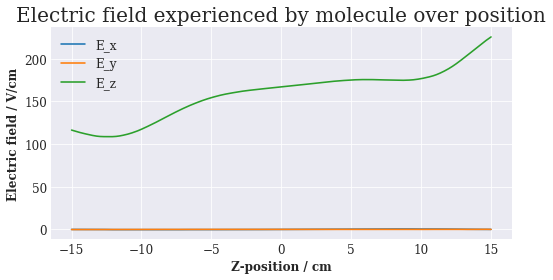

In [23]:
# Plot the electric field as a check:
ts, Es, ax = electric_field.plot(trajectory, position = True)

print(f"Max electric field: {np.max(Es):.2f} V/cm")
print(f"Electric field at z = 0: {E_R(np.array([0,0,0]))[2]:.2f} V/cm")

## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [24]:
B = np.array((0,0,1e-4))
# B = np.array((0.2,0.45,0.1))
def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3,1)) * np.ones(R.shape)

magnetic_field = MagneticField(B_R, R_t = trajectory.R_t)

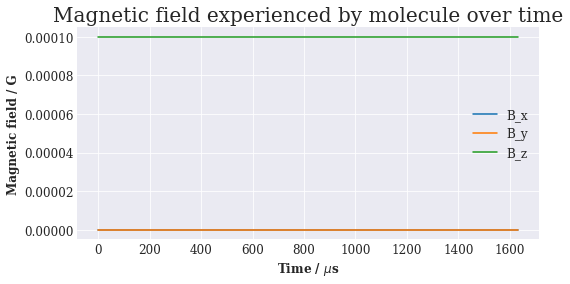

In [25]:
magnetic_field.plot(trajectory)

## Initial and final states
Define approximate initial states here.

In [26]:
#Define useful approximate states
#Lens states
J2_singlet = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                            -1* UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J2_triplet_0 = 1/np.sqrt(2) * (1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')
                            +1* UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X'))

J2_triplet_p = 1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X')

J2_triplet_m = 1*UncoupledBasisState(J = 2, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = +1, Omega = 0, electronic_state='X')

J2_mJ1pp = 1*UncoupledBasisState(J = 2, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = +1, Omega = 0, electronic_state='X')


#J = 1, m_J = +/-1 states
J1_ppp = 1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')
J1_ppm = 1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
J1_pmp = 1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')
J1_pmm = 1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
J1_mpp = 1*UncoupledBasisState(J = 1, mJ = -1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')
J1_mpm = 1*UncoupledBasisState(J = 1, mJ = -1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')
J1_mmp = 1*UncoupledBasisState(J = 1, mJ = -1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X')
J1_mmm = 1*UncoupledBasisState(J = 1, mJ = -1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2, P = -1, Omega = 0, electronic_state='X')

#L and I are superposition states, define them here
J1_L = (J1_pmm - J1_mpp)/np.sqrt(2)
J1_I = (J1_pmm + J1_mpp)/np.sqrt(2)

initial_states_approx_z = [J2_singlet, J2_triplet_m, J2_triplet_0, J2_triplet_p]
final_state = J1_pmp

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [27]:
Js = [0,1,2,3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)
# hamiltonian = SlowHamiltonianOld(0, 3, trajectory, electric_field, magnetic_field, '../hamiltonians/TlF_X_state_hamiltonian0to3_2020_03_03.pickle')

## Find what state at t = 0 corresponds to the desired initial states
At t = 0 the electric field is not along z, so the eigenstates look different. Track the staet evolution from a perfectly along z-field to the field at t = 0 zero to make sure we pick the correct initial states

In [28]:
E_t0 = electric_field.E_t(0)
magE0 = np.sqrt(np.sum(E_t0**2))

Start with the electric field perfectly along z and then add some of the non-z component to the electric field while keeping track of whihc state corresponds to which

In [29]:
# Define values for Ex and Ey that slowly tend to towards the actual values at t=0
Exs = np.linspace(0, E_t0[0], 100)
Eys = np.linspace(0, E_t0[1], 100)

# Store energies of each state for checking later
energies = np.empty((len(Exs), len(hamiltonian.QN)))

# Find the eigenvectors when the electric field is fully along z
H_z = hamiltonian.H_EB(np.array([0,0,magE0]), magnetic_field.B_t(0))
E_ref, V_ref = np.linalg.eigh(H_z)
V_ref_ini = V_ref

# Find the indices of the states of interest
idxs = [find_max_overlap_idx(state.state_vector(hamiltonian.QN), V_ref_ini) for state in initial_states_approx_z]

# Loop over Ex and Ey and keep track of which state corresponds to which
for i, (Ex, Ey) in enumerate(zip(Exs, Eys)):
    Ez = np.sqrt(magE0**2 - Ex**2 - Ey**2)
    H = hamiltonian.H_EB(np.array([Ex,Ey, Ez]), magnetic_field.B_t(0))
    D, V = np.linalg.eigh(H)
    
    # Reorder eigenvectors and energies
    Es, evecs = reorder_evecs(V, D, V_ref)
    
    V_ref = evecs
    energies[i,:] = Es

# Set the states in the rotated electric field as the initial states
initial_states_approx = matrix_to_states(V_ref[:, idxs], hamiltonian.QN)

Define a function to map states with E along z to initial direction of E

In [30]:
def map_state(state):
    # Find index of state
    idx = find_max_overlap_idx(state.state_vector(hamiltonian.QN), V_ref_ini)
    
    # Return state
    return vector_to_state(V_ref[:,idx], hamiltonian.QN)

def map_state_reverse(state):
    # Find index of state
    idx = find_max_overlap_idx(state.state_vector(hamiltonian.QN), V_ref)
    
    # Return state
    return vector_to_state(V_ref_ini[:,idx], hamiltonian.QN)

## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

### J = 1 to 2 microwaves

In [31]:
# Define states
state1 = J2_singlet
state2 = J1_pmp
# state2 = J1_ppm

# Center position
R0 = np.array((0.00,0,0.0))

#### Polarization:
# Define polarization components
p_x = np.array([1, 0, 0])
p_y = np.array([0, 1, 0])
p_z = np.array([0, 0, 1])
p_plus = np.array([1, -1j, 0])/np.sqrt(2)
p_minus = np.array([1, +1j, 0])/np.sqrt(2)

# Define a function that gives the main component of the polarization (in xyz basis) as a function of position
theta = 0/180*np.pi
p_main = np.cos(theta/2)* p_plus + np.sin(theta/2)*p_minus + 0.*p_z
# p_main = p_x+p_y+p_z
P_R = lambda R: p_main/np.sqrt(np.sum(np.abs(p_main)**2))

# Define k-vector (in XYZ coordinates)
k = np.array((1,0,0))
pol = Polarization(P_R, k, f_long = 1, dir_long = np.array([0,0,1]))

#### Frequency
#Calculate the microwave frequency between specified states at a specific point
muW_freq_2 = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
print(f"Transition frequency at center of SPB microwaves: {muW_freq_2/1e9:.5f} GHz")

#### Intensity profile:
# Define a Gaussian intensity profile
intensity = BesselGaussianBeam(power = 1e-3, w0 = 4.56e-2, alpha = 78.9, R0 = R0, k = k, freq = muW_freq_2)
# intensity = MeasuredBeam(power = 1e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq_2)
# intensity = GaussianBeam(power = 0.5e-3, sigma = 1*25.4e-3/(2*np.sqrt(2*np.log(2))), R0 = R0, k = k, freq = muW_freq_2)

#### Define MicrowaveField
mf12 = MicrowaveField(1, 2, intensity, pol, muW_freq_2, hamiltonian.QN)

Transition frequency at center of SPB microwaves: 26.67084 GHz


### Define list of microwave fields

In [32]:
microwave_fields = [mf12]

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [33]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian, microwave_fields)

In [36]:
# Set microwave parameters
## Center postion
R0 = np.array([0.00,0,0.0])

## Sigma
mf12.intensity.sigma = 1.0*25.4e-3/(2*np.sqrt(2*np.log(2)))

## Frequency
freq = calculate_transition_frequency(state1, state2, hamiltonian.H_R(R0), hamiltonian.QN)
detuning = 20e3
mf12.set_frequency(freq + detuning)
mf12.set_position(R0)

## Power
# Calculate and set the microwave power needed for given Rabi rate
mf12.calculate_microwave_power(state1, state2, 2*np.pi*15e3, R0)
# mf12.set_power(2.6e-5)

# Molecule parameters
trajectory.Rini = np.array([0,0.0,-150e-3])
trajectory.Vini = np.array([0,0,184])
trajectory.zfin = 150e-3

In [37]:
result = simulator.run(N_steps = 10000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:32<00:00, 305.07it/s]


## Plot results

### State evolution for main state

Probability of target state: 0.993
Power = 6.0E-05W = -12.2 dBm


C:\Users\Oskari\Anaconda3\envs\state_prep\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


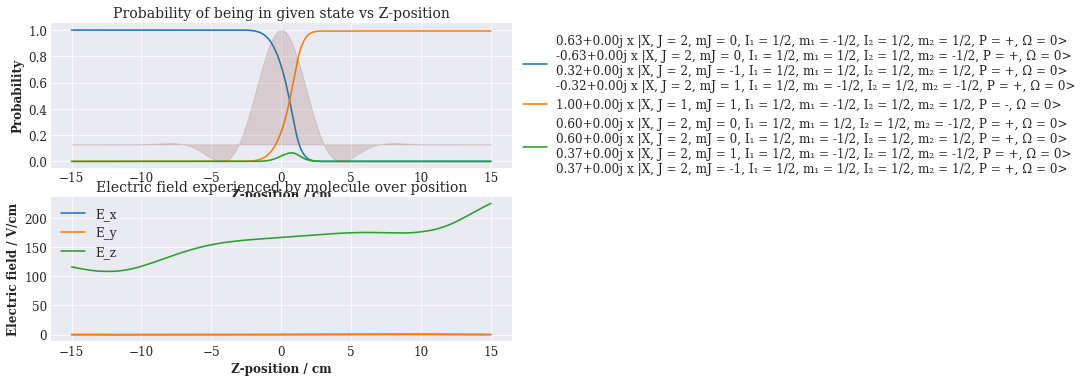

In [38]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N = 3)
fig, (ax, ax2) = plt.subplots(2,1, figsize = (210/25.4,1.5*297/25.4/3), constrained_layout = True)
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, position = True, state_mapper = map_state_reverse)
legend_labels = [
    r'$|J = 1, m_J = 1,\downarrow,\uparrow\rangle$',
    r'$|J = 2, m_J = 0, S = 0\rangle$',
    r'$|J = 2, m_J = 0, S = 1, m_S = 0\rangle$',
    
]
ax.legend(bbox_to_anchor = (1,1))
# ax.axvline(x = R0[2]*1e2, ls ='--', c = 'k')
# ax.set_title(f"Power = ${mf12.intensity.power:.1E}$ W")
ax.set_title("Probability of being in given state vs Z-position", fontsize = 14)
ax.set_ylabel('Probability')

# Show microwave polarization components
t_array = result.t_array
Rs = np.array([trajectory.R_t(t) for t in t_array])
pols = np.array([mf12.p_t(t) for t in result.t_array])
Omegas_R = np.array([mf12.intensity.E_R(trajectory.R_t(t)) for t in t_array])
ax_twin = ax.twinx()
ax_twin.grid(False)
ax_twin.fill_between(Rs[:,2]*100,Omegas_R/Omegas_R.max()*np.real(pols[:,0]), color = 'C5', alpha = 0.2, label = 'Microwave Rabi rate')
ax_twin.set_yticks([])
# ax_twin.fill_between(Rs[:,2]*100,Omegas_R/Omegas_R.max()*np.imag(pols[:,2]), color = 'C1', alpha = 0.3, label = 'π')

lines = ax.lines
collections = ax_twin.collections
objects = lines+collections
labels = legend_labels + [c.get_label() for c in collections]
# ax.legend(objects, labels, fontsize = 14)


Es, _, _ = electric_field.plot(trajectory, position=True, ax = ax2)
ax2.set_title('Electric field experienced by molecule over position', fontsize = 14)
print(f"Probability of target state: {result.get_state_probability(map_state(J1_pmp), initial_state)[-1]:.3f}")
print(f"Power = {mf12.intensity.power:.1E}W = {10*np.log10(mf12.intensity.power)+30:.1f} dBm")

# plt.savefig('../../figures/SPB/state_evolution_pmp_BG_high_E.pdf')

### State evolution for other J = 2, m_J = 0 states

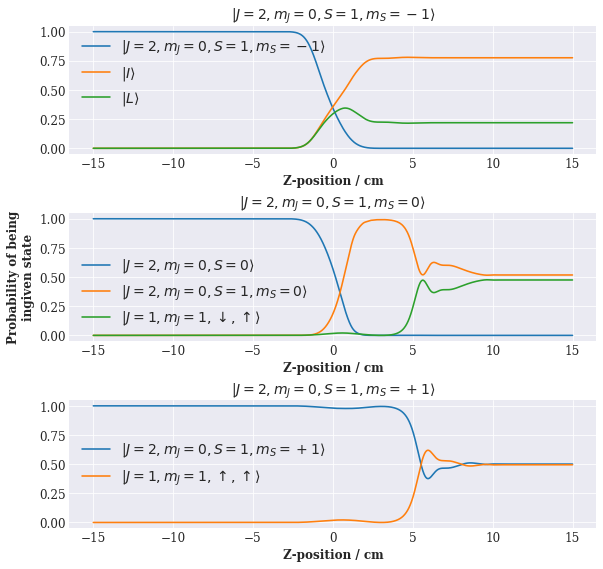

In [55]:
fig, axs = plt.subplots(3,1, figsize = (210/25.4,2*297/25.4/3), constrained_layout = True)
titles = [
    r'$|J = 2, m_J = 0, S = 1, m_S = -1\rangle$',
    r'$|J = 2, m_J = 0, S = 1, m_S = 0\rangle$',
    r'$|J = 2, m_J = 0, S = 1, m_S = +1\rangle$'
]
Ns = [3,3,2]
legend_labels = [
    [
        r'$|J = 2, m_J = 0, S = 1, m_S = -1\rangle$',
        r'$|I\rangle$',
        r'$|L\rangle$',
    ],
    [
        r'$|J = 2, m_J = 0, S = 0\rangle$',
        r'$|J = 2, m_J = 0, S = 1, m_S = 0\rangle$',
        r'$|J = 1, m_J = 1,\downarrow,\uparrow\rangle$',
    ],
    [
        r'$|J = 2, m_J = 0, S = 1, m_S = +1\rangle$',
        r'$|J = 1, m_J = 1, \uparrow,\uparrow\rangle$',
    ]
]

for i, initial_state in enumerate(result.initial_states[1:]):
    ax = axs[i]
    title = titles[i]
    N = Ns[i]
    labels = legend_labels[i]
    large_prob_states = result.find_large_prob_states(initial_state, N = N)
    result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, position = True, state_mapper=map_state_reverse)
    # ax.legend(fontsize = 14, bbox_to_anchor = (1,1))
    ax.legend(fontsize = 14, labels = labels)
    # ax.axvline(x = R0[2]*1e2, ls ='--', c = 'k')
    ax.set_title(title, fontsize = 14)
    
axs[1].set_ylabel('Probability of being\ningiven state')
    
plt.savefig('../../figures/SPB/state_evolution_pmp_ideal_other_ini_states_high_E_BG_detuning_20kHz_power_60e-6W.pdf')

### Coupling strengths

In [22]:
%%time
# coupling_plotter = CouplingPlotter(
#     [(J2_singlet, J1_pmp), (J2_singlet, J1_ppm), (J2_singlet, J1_I), (J2_singlet, J1_L)],
#     result.hamiltonian,
#     result.electric_field,
#     result.microwave_fields[0],
#     np.array([result.t_array[len(result.t_array)//2]]))

coupling_plotter = CouplingPlotter(
    [(map_state(J2_singlet), map_state(J1_pmp)), (map_state(J2_singlet), map_state(J1_ppm)), (map_state(J2_singlet), map_state(J1_I)), (map_state(J2_singlet), map_state(J1_L))],
    result.hamiltonian,
    result.electric_field,
    result.microwave_fields[0],
    np.array(result.t_array))

CPU times: total: 1min 27s
Wall time: 30.2 s


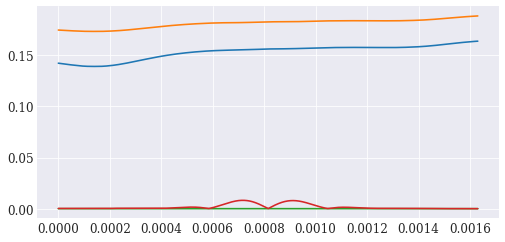

In [23]:
fig, ax = plt.subplots()
coupling_plotter.plot_coupling_strengths(ax = ax)
# ax.legend()

In [24]:
for couplings in coupling_plotter.MEs:
    print(couplings[len(couplings)//2])

(-0.14429152499106535-0.059734197026029744j)
(0.09063487097594226+0.15866874345600568j)
(-1.974371121414162e-09-3.518816147065722e-09j)
(-1.6149532690007072e-05-2.9698227842478133e-05j)


### Plot energies for the allowed transitions

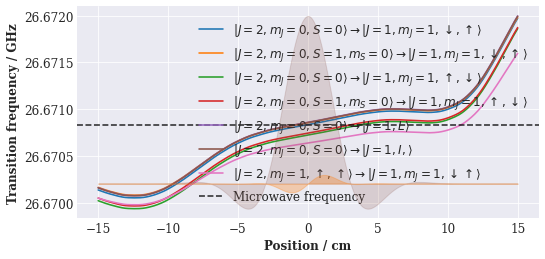

In [28]:
# J = 2 states
E_J2_singlet = result.get_state_energy(map_state(J2_singlet))
E_J2_triplet_m = result.get_state_energy(map_state(J2_triplet_m))
E_J2_triplet_0 = result.get_state_energy(map_state(J2_triplet_0))
E_J2_triplet_p = result.get_state_energy(map_state(J2_triplet_p))

E_J2_mJ1pp = result.get_state_energy(map_state(J2_mJ1pp))

# J = 1 states
E_J1_pmp = result.get_state_energy(map_state(J1_pmp))
E_J1_ppm = result.get_state_energy(map_state(J1_ppm))
E_J1_L = result.get_state_energy(map_state(J1_L))
E_J1_I = result.get_state_energy(map_state(J1_I))

# Calculate frequencies
f_J2_singlet_pmp = (E_J2_singlet - E_J1_pmp)/(2*np.pi*1e9)
f_J2_triplet_0_pmp = (E_J2_triplet_0 - E_J1_pmp)/(2*np.pi*1e9)

f_J2_singlet_ppm = (E_J2_singlet - E_J1_ppm)/(2*np.pi*1e9)
f_J2_triplet_0_ppm = (E_J2_triplet_0 - E_J1_ppm)/(2*np.pi*1e9)

f_J2_singlet_L = (E_J2_singlet - E_J1_L)/(2*np.pi*1e9)
f_J2_singlet_I = (E_J2_singlet - E_J1_I)/(2*np.pi*1e9)

f_J2_mJ1pp_pmp = (E_J2_mJ1pp - E_J1_pmp)/(2*np.pi*1e9)


# Plot the frequencies
fig, ax = plt.subplots()
ax.plot(result.z_array*100, f_J2_singlet_pmp, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, m_J = 1, \downarrow,\uparrow\rangle$')
ax.plot(result.z_array*100, f_J2_triplet_0_pmp, label = r'$|J = 2, m_J = 0, S = 1, m_S =0\rangle\rightarrow |J = 1, m_J = 1, \downarrow,\uparrow\rangle$')
ax.plot(result.z_array*100, f_J2_singlet_ppm, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, m_J = 1, \uparrow,\downarrow\rangle$')
ax.plot(result.z_array*100, f_J2_triplet_0_ppm, label = r'$|J = 2, m_J = 0, S = 1, m_S =0\rangle\rightarrow |J = 1, m_J = 1, \uparrow,\downarrow\rangle$')
ax.plot(result.z_array*100, f_J2_singlet_L, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1,L\rangle$')
ax.plot(result.z_array*100, f_J2_singlet_I, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1,I, \rangle$')
ax.plot(result.z_array*100, f_J2_mJ1pp_pmp, label = r'$|J = 2, m_J = 1,\uparrow,\uparrow\rangle\rightarrow |J = 1,m_J = 1,\downarrow\uparrow\rangle$')


# Show frequency of microwaves
ax.axhline(muW_freq_2/(1e9), ls = '--', c = 'k', alpha = 0.8, label =  'Microwave frequency')


# Show microwave polarization components
t_array = result.t_array
Rs = np.array([trajectory.R_t(t) for t in t_array])
pols = np.array([mf12.p_t(t) for t in result.t_array])
Omegas_R = np.array([mf12.intensity.E_R(trajectory.R_t(t)) for t in t_array])
ax_twin = ax.twinx()
ax_twin.grid(False)
ax_twin.fill_between(Rs[:,2]*100,Omegas_R/Omegas_R.max()*np.real(pols[:,0]), color = 'C5', alpha = 0.2, label = 'Microwave Rabi rate')
ax_twin.set_yticks([])
ax_twin.fill_between(Rs[:,2]*100,Omegas_R/Omegas_R.max()*np.imag(pols[:,2]), color = 'C1', alpha = 0.3, label = 'π')


ax.set_xlabel('Position / cm')
ax.set_ylabel('Transition frequency / GHz')
ax.legend(loc = 'center right', fontsize = 12)
ax.margins(0.05)



### Plot frequencies relative to microwave frequency

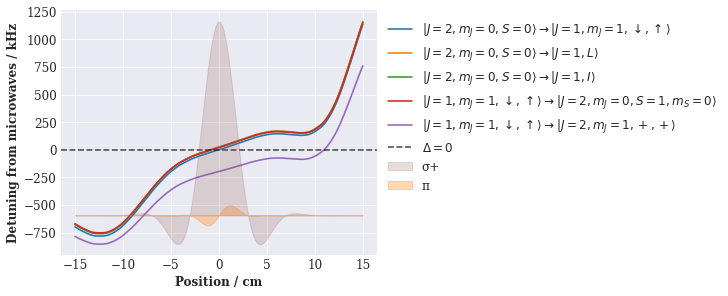

In [39]:
# J = 2 states
E_J2_singlet = result.get_state_energy(map_state(J2_singlet))
E_J2_triplet_m = result.get_state_energy(map_state(J2_triplet_m))
E_J2_triplet_0 = result.get_state_energy(map_state(J2_triplet_0))
E_J2_triplet_p = result.get_state_energy(map_state(J2_triplet_p))
E_J2_mJ1pp = result.get_state_energy(map_state(J2_mJ1pp))

# J = 1 states
E_J1_pmp = result.get_state_energy(map_state(J1_pmp))
E_J1_ppm = result.get_state_energy(map_state(J1_ppm))
E_J1_ppp = result.get_state_energy(map_state(J1_ppp))
E_J1_L = result.get_state_energy(map_state(J1_L))
E_J1_I = result.get_state_energy(map_state(J1_I))

# Calculate frequencies
f_J2_singlet_pmp = (E_J2_singlet - E_J1_pmp)/(2*np.pi*1e3) - muW_freq_2/1e3
f_J2_triplet_0_pmp = (E_J2_triplet_0 - E_J1_pmp)/(2*np.pi*1e3) - muW_freq_2/1e3

f_J2_singlet_ppm = (E_J2_singlet - E_J1_ppm)/(2*np.pi*1e3) - muW_freq_2/1e3
f_J2_triplet_0_ppm = (E_J2_triplet_0 - E_J1_ppm)/(2*np.pi*1e3) - muW_freq_2/1e3

f_J2_singlet_L = (E_J2_singlet - E_J1_L)/(2*np.pi*1e3) - muW_freq_2/1e3
f_J2_singlet_I = (E_J2_singlet - E_J1_I)/(2*np.pi*1e3) - muW_freq_2/1e3
f_J2_mJ1pp_pmp = (E_J2_mJ1pp - E_J1_pmp)/(2*np.pi*1e3) - muW_freq_2/1e3

f_J2_triplet_p_ppp = (E_J2_triplet_p - E_J1_ppp)/(2*np.pi*1e3)- muW_freq_2/1e3
f_J2_triplet_m_I = (E_J2_triplet_m - E_J1_I)/(2*np.pi*1e3)- muW_freq_2/1e3
f_J2_triplet_m_L = (E_J2_triplet_m - E_J1_L)/(2*np.pi*1e3)- muW_freq_2/1e3


# Plot the frequencies
fig, ax = plt.subplots(figsize =(10,4), constrained_layout = True)
# ax.set_xlim((-10,10))
# ax.set_ylim(-75,75)

ax.plot(result.z_array*100, f_J2_singlet_pmp, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, m_J = 1, \downarrow,\uparrow\rangle$')
ax.plot(result.z_array*100, f_J2_singlet_L, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, L\rangle$')
ax.plot(result.z_array*100, f_J2_singlet_I, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, I \rangle$')
ax.plot(result.z_array*100, f_J2_triplet_0_pmp, label = r'$|J = 1, m_J = 1, \downarrow,\uparrow\rangle\rightarrow |J = 2, m_J = 0, S = 1, m_S =0\rangle$')
# ax.plot(result.z_array*100, f_J2_singlet_ppm, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, m_J = 1, \uparrow,\downarrow\rangle$')
# ax.plot(result.z_array*100, f_J2_triplet_0_ppm, label = r'$|J = 2, m_J = 0, S = 1, m_S =0\rangle\rightarrow |J = 1, m_J = 1, \uparrow,\downarrow\rangle$')
ax.plot(result.z_array*100, f_J2_mJ1pp_pmp, label = r'$|J = 1,m_J = 1,\downarrow,\uparrow\rangle\rightarrow |J = 2, m_J = 1,+,+\rangle$')
ax.axhline(0, ls = '--', c = 'k', alpha = 0.7, label = r'$\Delta = 0$')



# Show microwave polarization components
t_array = result.t_array
Rs = np.array([trajectory.R_t(t) for t in t_array])
pols = np.array([mf12.p_t(t) for t in result.t_array])
Omegas_R = np.array([mf12.intensity.E_R(trajectory.R_t(t)) for t in t_array])
ax_twin = ax.twinx()
ax_twin.grid(False)
ax_twin.fill_between(Rs[:,2]*100,Omegas_R/Omegas_R.max()*np.real(pols[:,0]), color = 'C5', alpha = 0.2, label = 'σ+')
ax_twin.set_yticks([])
ax_twin.fill_between(Rs[:,2]*100,Omegas_R/Omegas_R.max()*np.imag(pols[:,2]), color = 'C1', alpha = 0.3, label = 'π')

objects = ax.lines + ax_twin.collections
labels = [o.get_label() for o in objects]

ax.set_xlabel('Position / cm')
ax.set_ylabel('Detuning from microwaves / kHz')
ax.legend(objects, labels, loc = 'upper left', fontsize = 12, bbox_to_anchor = (1,1))
ax.margins(0.05)

fig.savefig('../../figures/SPB/SPB_high_E_detunings_target_state_BG.pdf')

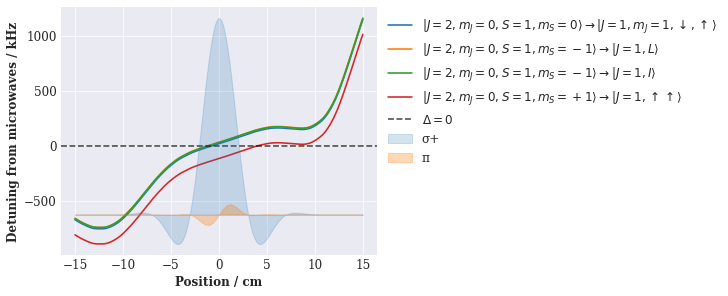

In [40]:
# Plot the frequencies
fig, ax = plt.subplots(figsize =(10,4), constrained_layout = True)
# ax.set_xlim((-10,10))
# ax.set_ylim(-160,150)

# ax.plot(result.z_array*100, f_J2_singlet_pmp, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, m_J = 1, \downarrow,\uparrow\rangle$')
# ax.plot(result.z_array*100, f_J2_singlet_L, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, L\rangle$')
# ax.plot(result.z_array*100, f_J2_singlet_I, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, I \rangle$')
ax.plot(result.z_array*100, f_J2_triplet_0_pmp, label = r'$|J = 2, m_J = 0, S = 1, m_S =0\rangle\rightarrow |J = 1, m_J = 1, \downarrow,\uparrow\rangle$')
ax.plot(result.z_array*100, f_J2_triplet_m_L, label = r'$|J = 2, m_J = 0, S = 1, m_S =-1\rangle\rightarrow |J = 1, L\rangle$')
ax.plot(result.z_array*100, f_J2_triplet_m_I, label = r'$|J = 2, m_J = 0, S = 1, m_S =-1\rangle\rightarrow |J = 1, I\rangle$')
ax.plot(result.z_array*100, f_J2_triplet_p_ppp, label = r'$|J = 2, m_J = 0, S = 1, m_S =+1\rangle\rightarrow |J = 1, \uparrow\uparrow\rangle$')
# ax.plot(result.z_array*100, f_J2_singlet_ppm, label = r'$|J = 2, m_J = 0, S = 0\rangle\rightarrow |J = 1, m_J = 1, \uparrow,\downarrow\rangle$')
# ax.plot(result.z_array*100, f_J2_triplet_0_ppm, label = r'$|J = 2, m_J = 0, S = 1, m_S =0\rangle\rightarrow |J = 1, m_J = 1, \uparrow,\downarrow\rangle$')
# ax.plot(result.z_array*100, f_J2_mJ1pp_pmp, label = r'$|J = 2, m_J = 1,+,+\rangle\rightarrow |J = 1,m_J = 1,\downarrow\uparrow, \rangle$')
ax.axhline(0, ls = '--', c = 'k', alpha = 0.7, label = r'$\Delta = 0$')

# Show microwave polarization components
t_array = result.t_array
Rs = np.array([trajectory.R_t(t) for t in t_array])
pols = np.array([mf12.p_t(t) for t in result.t_array])
Omegas_R = np.array([mf12.intensity.E_R(trajectory.R_t(t)) for t in t_array])
ax_twin = ax.twinx()
ax_twin.grid(False)
ax_twin.fill_between(Rs[:,2]*100,Omegas_R/Omegas_R.max()*np.real(pols[:,0]), color = 'C0', alpha = 0.2, label = 'σ+')
ax_twin.set_yticks([])
ax_twin.fill_between(Rs[:,2]*100,Omegas_R/Omegas_R.max()*np.imag(pols[:,2]), color = 'C1', alpha = 0.3, label = 'π')


objects = ax.lines + ax_twin.collections
labels = [o.get_label() for o in objects]

ax.set_xlabel('Position / cm')
ax.set_ylabel('Detuning from microwaves / kHz')
ax.legend(objects, labels, loc = 'upper left', fontsize = 12, bbox_to_anchor = (1,1))
ax.margins(0.05)

fig.savefig('../../figures/SPB/SPB_high_E_detunings_triplet_states_BG.pdf')

### Plot intensity profile
Check that the longitudinal polarization appears correctly

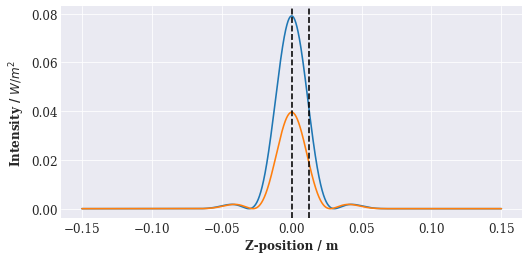

In [32]:
Rs = np.array([trajectory.R_t(t) for t in result.t_array])
intensities_R = np.array([mf12.intensity.I_R(trajectory.R_t(t)) for t in result.t_array])
intensities = np.array([mf12.intensity.I_R(np.array([0.0,0.0127,z])) for z in Rs[:,2]])

fig, ax = plt.subplots()
ax.plot(Rs[:,2],intensities_R)
ax.plot(Rs[:,2],intensities)
ax.set_xlabel("Z-position / m")
ax.set_ylabel(r"Intensity / $W/m^2$")
ax.axvline(x = R0[2], ls ='--', c = 'k')
ax.axvline(x = 0.0127, ls ='--', c = 'k')

### Plot polarization components

In [121]:
pols = np.array([mf12.p_t(t) for t in result.t_array])

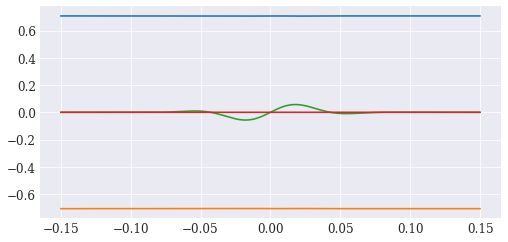

In [48]:
fig, ax = plt.subplots()
ax.plot(Rs[:,2], np.real(pols[:,0]), label = 'x')
ax.plot(Rs[:,2], np.imag(pols[:,1]), label = 'y')
ax.plot(Rs[:,2], np.imag(pols[:,2]), label = 'z_imag')
ax.plot(Rs[:,2], np.real(pols[:,2]), label = 'z_real')

## Parameter scans - J = 1 to 2
### Helper functions
Define two helper function to run the power scans:

In [43]:
def run_simulation(power: float, detuning: float, R0: np.ndarray, Rini:np.ndarray, Vini: np.ndarray, initial_state: centrex_TlF.State, target_state: centrex_TlF.State, second_target:centrex_TlF.State, r: float, phi:float, save_path: Path = None, N_steps = 10000):
    """
    Runs the simulation for one value of power and finds the probability of ending up in the target state.
    """
    ## Microwave settings    
    # Set position
    mf12.set_position(R0)
    
    # Set frequency
    freq = calculate_transition_frequency(initial_state, target_state, hamiltonian.H_R(R0), hamiltonian.QN)
    mf12.set_frequency(freq + detuning)
    mf12.set_position(R0)

    # Set power
    mf12.set_power(power)
    
    # Set polarization
    # Define a function that gives the main component of the polarization as a function of position
    p_main = (p_plus - p_minus + r*np.exp(1j*phi)*(p_plus + p_minus))
    P_R = lambda R: p_main/np.sqrt(np.sum(np.abs(p_main)**2))
    # Define k-vector (in XYZ coordinates
    k = np.array((1,0,0))
    pol = Polarization(P_R, k, f_long = 1, dir_long = np.array([0,0,1]))
    mf12.polarization = pol

    # Trajectory settings
    trajectory.Rini = Rini
    trajectory.Vini = Vini
    
    # Run the simulator
    result = simulator.run(N_steps = N_steps)
    
    # Save result if save path provided
    if save_path:
        result.save_to_pickle(save_path)
    
    # Determine probability to be in initial state
    prob_ini = result.get_state_probability(map_state(initial_state), initial_state = result.initial_states[0])[-1]

    # Determine probability to be in target state
    prob_fin = result.get_state_probability(map_state(target_state), initial_state = result.initial_states[0])[-1]
    
    # Determine probability to be in time-reversed version of target state
    prob_T = result.get_state_probability(map_state(target_state.time_reversed()), initial_state = result.initial_states[0])[-1]
    
    # Determine probability to be in the other target state
    prob_st =  result.get_state_probability(map_state(second_target), initial_state = result.initial_states[0])[-1]
    
    # Return a dataframe
    df = pd.DataFrame({"power":[power], "detuning":[detuning], "muw_position": [R0], "Rini":[Rini], "Vini":[Vini],  "prob_ini":[prob_ini], "prob_fin": [prob_fin], "prob_T": [prob_T], "prob_st": [prob_st], 'axial_ratio':r, 'phase_offset':phi, "save_path": [save_path]})
    
    return df

In [44]:
# Define the function to be run in parallel
def parallel_func(power = 10**(-4.1), detuning = 0, R0 = np.array([0.00,0,0.0]), Rini = np.array((0,0,-100e-3)), Vini = np.array((0,0,184.)), r = 1, phi = 0, save = False, N_steps = 10000):
    save_path = SAVE_DIR / Path(f"result_{generate_random_key()}") if save else None
    return run_simulation(power, detuning, R0, Rini, Vini, J2_singlet, J1_pmp, J1_ppm, r = r, phi = phi, save_path=save_path, N_steps = N_steps)

In [125]:
# Function for generating random keys for the results
def generate_random_key(length: int = 6):
    return ''.join(random.choices(string.ascii_letters + string.digits, k = length))

In [126]:
run_simulation(mf12.intensity.power, 0, np.array([0.00,0,0.0]), trajectory.Rini, trajectory.Vini, J2_singlet, J1_pmp, J1_ppm, r=1, phi = np.pi/2, N_steps = 10000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:25<00:00, 398.97it/s]


,power,detuning,muw_position,Rini,Vini,prob_ini,prob_fin,prob_T,prob_st,axial_ratio,phase_offset,save_path
0,0.000058,0,"[0.0, 0.0, 0.0]","[0.0, 0.0, -0.15]","[0, 0, 184]",7.419315e-07,0.483981,0.483837,8.844072e-09,1,1.570796,None


### Save directory

In [45]:
SAVE_DIR = Path('../../results/SPB - parameter scans/high_E')

### Run power scan

In [46]:
# Power values
powers = 10**((np.linspace(-70,10,36)-30)/10) # in W

# Initialize parallel loop
df = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=power, detuning = 20e3,) for power in powers)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  36 out of  36 | elapsed:  2.8min finished


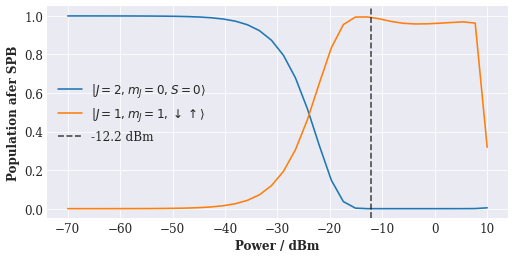

In [47]:
fig, ax = plt.subplots()
ax.plot(10*np.log10(df.power)+30, df.prob_ini, label = r'$|J = 2, m_J = 0, S = 0\rangle$')
ax.plot(10*np.log10(df.power)+30, df.prob_fin, label = r'$|J = 1, m_J = 1, \downarrow\uparrow\rangle$')
ax.axvline(-12.2, ls= '--', c = 'k', alpha = 0.7, label = '-12.2 dBm')
ax.set_xlabel("Power / dBm")
ax.set_ylabel("Population afer SPB")
ax.legend()
fig.savefig('../../figures/SPB/SPB_efficiency_vs_power_high_E_BG_detuning_20kHz.pdf')

### Frequency scan

In [48]:
# Define detunings
deltas = np.linspace(-0.300, 0.200, 41)*1e6 # in Hz

In [49]:
# run simulations for different parameters
df_freq = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=6.0e-5, detuning=delta, N_steps=10000) for delta in deltas)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  41 out of  41 | elapsed:  3.1min finished


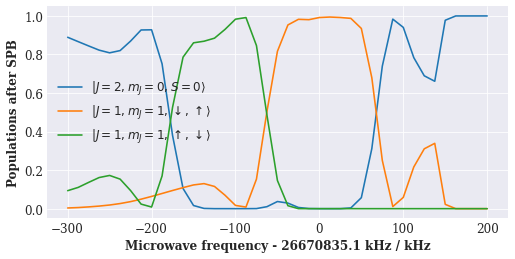

In [50]:
fig, ax = plt.subplots()
ax.plot(df_freq.detuning/1e3, df_freq.prob_ini, label = r'$|J = 2, m_J = 0, S = 0\rangle$')
ax.plot(df_freq.detuning/1e3, df_freq.prob_fin, label = r'$|J = 1, m_J = 1, \downarrow,\uparrow\rangle$')
ax.plot(df_freq.detuning/1e3, df_freq.prob_st, label = r'$|J = 1, m_J = 1, \uparrow,\downarrow\rangle$')
ax.set_xlabel(f"Microwave frequency - {muW_freq_2/1e3:.1f} kHz / kHz")
ax.set_ylabel("Populations after SPB")
ax.grid(True)
ax.legend()
fig.savefig('../../figures/SPB/SPB_efficiency_vs_freq_high_E_BG_power_60e-6W.pdf')

### Finer frequency scan

In [42]:
# Define detunings
deltas = np.linspace(-0.15, 0.15, 41)*1e6 # in Hz

In [43]:
# run simulations for different parameters
df_freq = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=5.8e-5, detuning=delta, N_steps=10000) for delta in deltas)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  41 out of  41 | elapsed:  4.1min finished


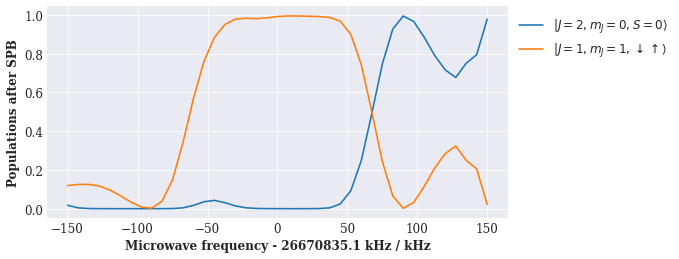

In [44]:
fig, ax = plt.subplots()
ax.plot(df_freq.detuning/1e3, df_freq.prob_ini, label = r'$|J = 2, m_J = 0, S = 0\rangle$')
ax.plot(df_freq.detuning/1e3, df_freq.prob_fin, label = r'$|J = 1, m_J = 1, \downarrow\uparrow\rangle$')
ax.set_xlabel(f"Microwave frequency - {muW_freq_2/1e3:.1f} kHz / kHz")
ax.set_ylabel("Populations after SPB")
ax.grid(True)
ax.legend(bbox_to_anchor = (1.0,1.0))

## Phase offset scan

In [51]:
phis = np.linspace(-1, 1, 36)*np.pi/2 # Phi is offset from pi/2 betweem x- and y-polarized components in rad

In [52]:
# run simulations for different parameters
df_phase = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=6.0e-5, detuning = 20e3, phi = phi, N_steps=10000) for phi in phis)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  36 out of  36 | elapsed:  2.6min finished


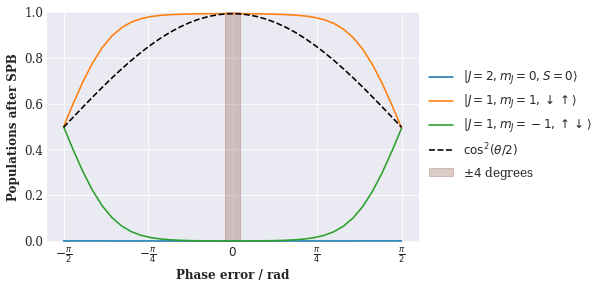

In [53]:
fig, ax = plt.subplots(constrained_layout = True)
ax.plot(df_phase.phase_offset, df_phase.prob_ini, label = r'$|J = 2, m_J = 0, S = 0\rangle$')
ax.plot(df_phase.phase_offset, df_phase.prob_fin, label = r'$|J = 1, m_J = 1, \downarrow\uparrow\rangle$')
ax.plot(df_phase.phase_offset, df_phase.prob_T, label = r'$|J = 1, m_J = -1, \uparrow\downarrow\rangle$')
ax.plot(df_phase.phase_offset, np.cos(df_phase.phase_offset/2)**2*np.max(df_phase.prob_fin), 'k--', label = r'$\cos^2(\theta/2)$')
ax.set_xlabel(f"Phase error / rad")
ax.set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2], [r'$-\frac{π}{2}$', r'$-\frac{π}{4}$', r'$0$', r'$\frac{π}{4}$', r'$\frac{π}{2}$'])
ax.set_ylabel("Populations after SPB")
ax.grid(True)
ax.fill_betweenx([0.00,1],-4*np.pi/180, 4*np.pi/180, alpha = 0.3, color = 'C5', label = r'$\pm4$ degrees')
objects = ax.lines + ax.collections
labels = [o.get_label() for o in objects]
ax.legend(objects, labels, bbox_to_anchor = (1,0.8))
ax.set_ylim([-.005,1])
ax.margins(0.05)
fig.savefig('../../figures/SPB/SPB_efficiency_vs_phase_offset_high_E_BG_power_60e-6W_detuning_20kHz.pdf')

### Save results
Save the dataframes for the plots

In [54]:
df.to_csv(SAVE_DIR / Path('SPB_eff_vs_power_detuning_20kHz.csv'))
df_freq.to_csv(SAVE_DIR / Path('SPB_eff_vs_freq_power_60e-6W.csv'))
df_phase.to_csv(SAVE_DIR / Path('SPB_eff_vs_phase_power_60e-6W_detuning_20kHz.csv'))

## Velocity scan

In [69]:
vzs = np.linspace(150, 300, 18)

# run simulations for different parameters
df_vz = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=5.8e-5, detuning = 20e3, Vini = np.array([0,0,vz]), Rini = np.array([0,0e-3, -150e-3]), N_steps=10000) for vz in vzs)).reset_index(drop=True)
df_vz_y15 = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=5.8e-5, detuning = 0, Vini = np.array([0,0,vz]), Rini = np.array([0,15e-3, -150e-3]), N_steps=10000) for vz in vzs)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  18 out of  18 | elapsed:  1.3min finished
[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  18 out of  18 | elapsed:  1.3min finished


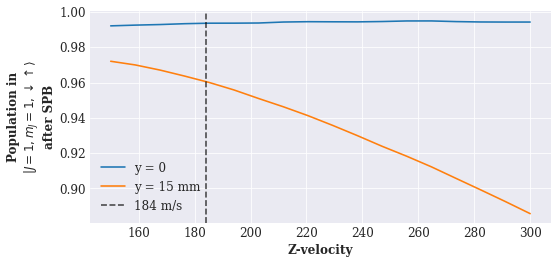

In [71]:
fig, ax = plt.subplots()
vzs = df_vz['Vini'].apply(lambda x: x[2])
ax.plot(vzs, df_vz.prob_fin, label = 'y = 0')
ax.plot(vzs, df_vz_y15.prob_fin, label = 'y = 15 mm')
ax.axvline(184, ls= '--', c = 'k', alpha = 0.7, label = '184 m/s')
ax.set_xlabel("Z-velocity")
ax.set_ylabel("Population in\n"+ r"$|J = 1, m_J = 1, \downarrow\uparrow\rangle$" + "\nafter SPB")
ax.legend()
# fig.savefig('../../figures/SPB/SPB_efficiency_vs_z-velocity_high_E_BG.pdf')

In [63]:
df_vz_y15

,power,detuning,muw_position,Rini,Vini,prob_ini,prob_fin,prob_T,prob_st,axial_ratio,phase_offset,save_path
0,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 150.0]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
1,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 158.8235294117647]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
2,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 167.64705882352942]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
3,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 176.47058823529412]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
4,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 185.29411764705884]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
5,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 194.11764705882354]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
6,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 202.94117647058823]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
7,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 211.76470588235293]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
8,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 220.58823529411765]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None
9,0.000058,20000.0,"[0.0, 0.0, 0.0]","[0.0, 0.015, 0.15]","[0.0, 0.0, 229.41176470588238]",1.0,2.611757e-23,2.398677e-24,8.633518e-24,1,0,None


## Phase offset and power scan

In [50]:
# Define detunings
phis = np.linspace(-1, 1, 36)*np.pi/2 # Phi is offset from pi/2 betweem x- and y-polarized components in rad
powers = 10**((np.linspace(-20,0,21)-30)/10)

params = product(phis, powers)

In [52]:
# run simulations for different parameters
df_freq = pd.concat(Parallel(n_jobs = 9, verbose = 1)(delayed(parallel_func)(power=power, phi=phi) for phi, power in params)).reset_index(drop=True)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:  2.8min
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed: 13.8min
[Parallel(n_jobs=9)]: Done 432 tasks      | elapsed: 31.5min
[Parallel(n_jobs=9)]: Done 756 out of 756 | elapsed: 53.4min finished


In [53]:
df_temp = df_freq.copy()

In [62]:
# df_temp.to_csv(SAVE_DIR / Path('phi_scans_at_different_powers_no_background.csv'))

In [55]:
df_temp['powermW'] = df_temp.power*1e3

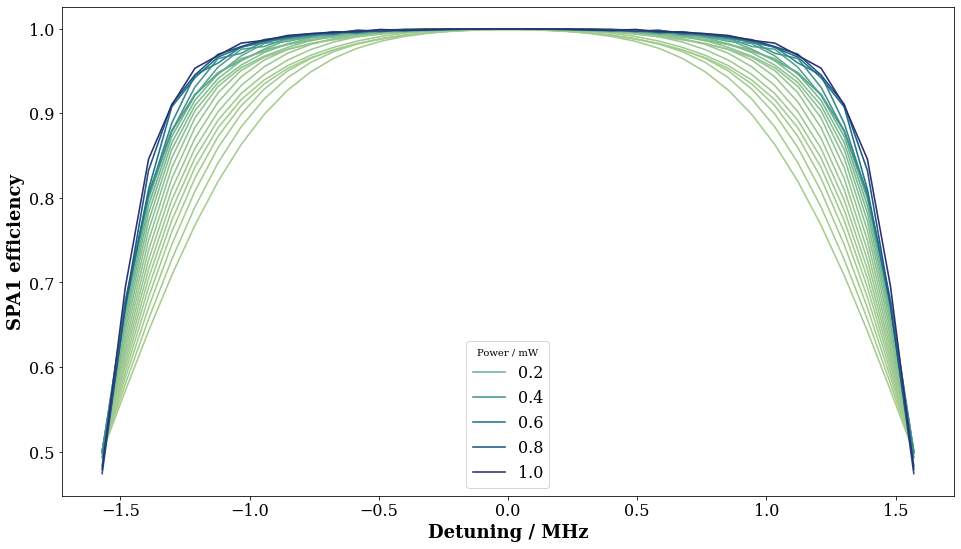

In [56]:
ax = sns.lineplot(data = df_temp, x = 'phase_offset', y = 'prob_fin', hue = 'powermW', palette='crest')
ax.set_xlabel("Phase offset / rad")
ax.set_ylabel("SPB efficiency")
ax.legend(title = 'Power / mW')
ax.grid()